In [1]:
import wave 
import numpy as np
import matplotlib.pyplot as plt

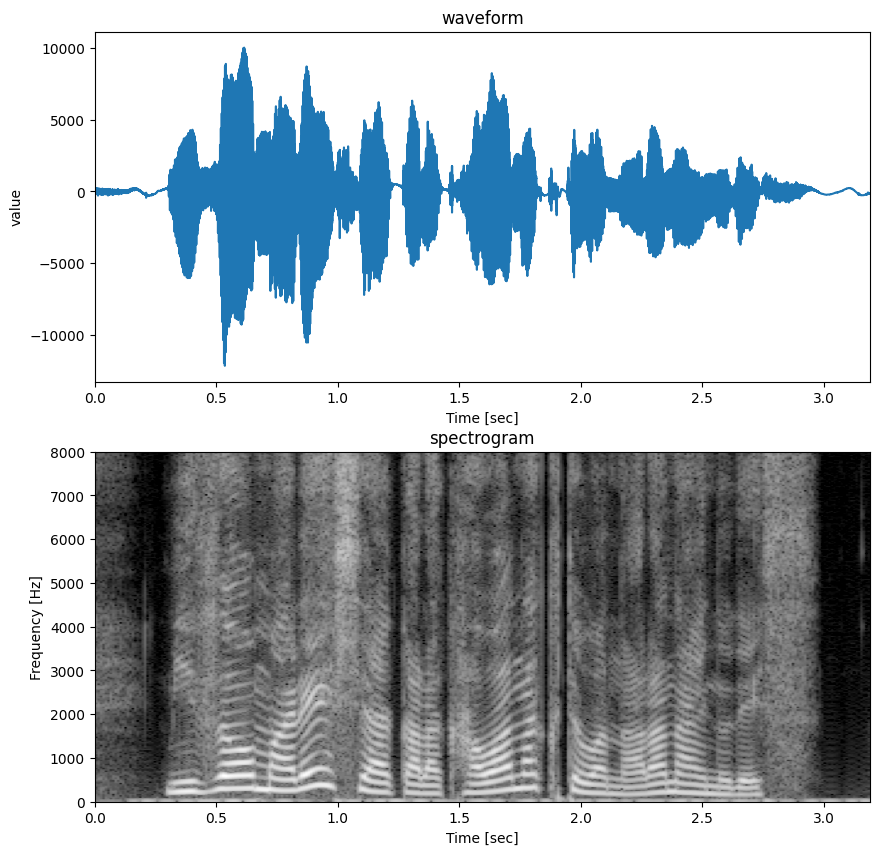

In [3]:
if __name__ == "__main__":
    # wav파일 열가
    wav_file = './data/wav/BASIC5000_0001.wav'
    # 프레임 사이즈[milli sec = ms]
    frame_size = 25
    # 프레임 시프트[milli sec = ms]
    frame_shift = 10
    
    #시각화 결과를 저장할 파일 이름(png file)
    out_plot = './spectrogram.png'
    
    #wav데이터 읽기 
    with wave.open(wav_file) as wav:
        sample_frequency = wav.getframerate()
        num_samples = wav.getnframes()
        waveform = wav.readframes(num_samples)
        waveform = np.frombuffer(waveform , dtype = np.int16)
    
    #프레임 사이즈를 ms에서 샘플수로 변환 
    frame_size = int(sample_frequency * frame_size * 0.001)
    #프레임 시프트를 ms에서 샘플수로 변환
    frame_shift = int(sample_frequency * frame_shift * 0.001)
    
    #FFT를 적용할 범위의 샘플 수를 프레임 사이즈보다 큰 2제곱으로 설정 
    fft_size = 1
    while fft_size < frame_size:
        fft_size *= 2
    
    #단시간 푸리에 변환을 했을 때의 총 프레임 수를 계산한다
    num_frames = (num_samples - frame_size) // frame_shift + 1 
    
    #스펙트로그램 행렬 준비
    spectrogram = np.zeros((num_frames, int(fft_size /2)+1))
    
    #프레임별 진폭 스펙트럼 계산하기
    
    for frame_idx in range(num_frames):
        #분석 시각 위치는, 프레임 번호(0시작) * (프레임 시프트)
        start_index = frame_idx * frame_shift 
        #1프레임만큼 파형 추출
        frame = waveform[start_index : start_index + frame_size].copy()
        #해밍 창 함수 적용
        frame = frame * np.hamming(frame_size)
        #로그 진폭 스펙트럼 계산
        spectrum = np.fft.fft(frame, n = fft_size)
        absolute = np.abs(spectrum)
        absolute = absolute[:int(fft_size / 2)+1]
        log_absolute = np.log(absolute + 1E-7)
        #계산 결과를 스펙트로그램으로 저장
        spectrogram[frame_idx, :] = log_absolute
        
    #시간 파형과 스펙트로그램 시각화 
    
    #시각화 영역 작성
    plt.figure(figsize = (10, 10))
    #시각화 영역을 세로로 2분할, 위에 시간 파형 그리기
    plt.subplot(2,1, 1)
    time_axis = np.arange(num_samples) / sample_frequency
    plt.plot(time_axis, waveform)
    plt.title('waveform')
    plt.xlabel('Time [sec]')
    plt.ylabel('value')
    plt.xlim([0, num_samples / sample_frequency])
    
    #2분할한 시각화 영역 하단에 스펙트로그램 그리기
    plt.subplot(2, 1, 2)
    #스펙트로그램 최대치를 0에 맞추어 color map범위조정
    spectrogram -= np.max(spectrogram)
    vmax = np.abs(np.min(spectrogram)) * 0.0
    vmin = -np.abs(np.min(spectrogram)) * 0.7
    #히스토그램 시각화
    plt.imshow(spectrogram.T[-1::-1, :],
              extent = [0, num_samples/sample_frequency, 0, sample_frequency/2],
              cmap = 'gray',
              vmax = vmax, vmin = vmin, aspect = 'auto')
    #그림 제목, x축과 y축 라벨 정의
    plt.title('spectrogram')
    plt.xlabel('Time [sec]')
    plt.ylabel('Frequency [Hz]')
    #시각화 결과 저장
    plt.savefig(out_plot)